In [1]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import math
%matplotlib inline

from variational_distributions import VariationalNormal, VariationalNormalNN

from torch.distributions import Normal

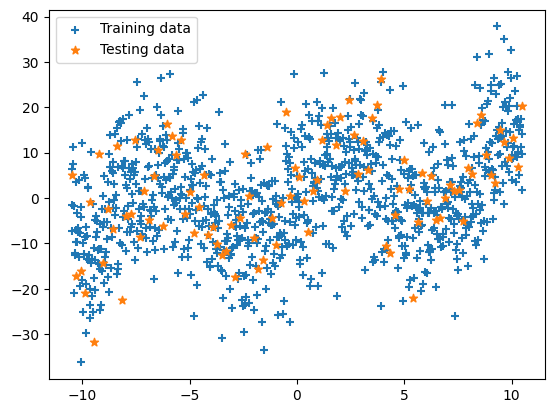

In [2]:
from random_data_generator import SinusoidalData, masegosa_sampleData
torch.manual_seed(2)
np.random.seed(1)
x_test,y_test = SinusoidalData(100)

torch.manual_seed(1)
np.random.seed(0)
x_train,y_train = SinusoidalData(1000)
plt.scatter(x_train[:,0], y_train, marker='+', label='Training data')
plt.scatter(x_test[:,0], y_test, marker='*', label='Testing data')
plt.legend()
plt.show()

In [64]:

from tqdm import trange


class BayesianNeuralNetwork:
    def __init__(self, x_train, y_train, x_test, y_test, theta_samples, loss, n_hidden = 20) -> None:
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.n = self.x_train.size(0)
        self.m = self.x_train.size(1)
        self.n_hidden = n_hidden
        self.variational_distribution = VariationalNormalNN(num_hidden=self.n_hidden)
        self.theta_samples = torch.Size([theta_samples])
        self.loss = loss 

    def log_prior(self, in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples):
        log_prior_in_weights = 0
        log_prior_in_bias = 0
        log_prior_out_weights = 0
        log_prior_out_bias = 0
        for sample_id in range(self.theta_samples[0]): 
            log_prior_in_weights += Normal(torch.zeros([1,self.n_hidden]),1).log_prob(in_weights_samples[sample_id]).sum()
            log_prior_in_bias += Normal(torch.zeros([1,self.n_hidden]),1).log_prob(in_bias_samples[sample_id]).sum() 
            log_prior_out_weights += Normal(torch.zeros([self.n_hidden,1]),1).log_prob(out_weights_samples[sample_id]).sum() 
            log_prior_out_bias += Normal(torch.zeros([self.n_hidden,1]),1).log_prob(out_bias_samples[sample_id]).sum() 

        return (log_prior_in_weights + log_prior_in_bias + log_prior_out_weights + log_prior_out_bias) / self.theta_samples[0]

    def log_likelihood(self, in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples):
        loglik = []
        for sample_id in range(self.theta_samples[0]): 
            hidden_layer = torch.tanh(torch.matmul(self.x_train,in_weights_samples[sample_id]) + in_bias_samples[sample_id])
            out = torch.matmul(hidden_layer,out_weights_samples[sample_id]) + out_bias_samples[sample_id]

            loglik.append(
                Normal(out, 1).log_prob(self.y_train)
            )

        return torch.cat(loglik, -1)

    def log_q(self, in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples):
        log_q = 0

        for sample_id in range(self.theta_samples[0]): 
            log_q += sum(self.variational_distribution.log_q(in_weights_samples[sample_id], in_bias_samples[sample_id], out_weights_samples[sample_id], out_bias_samples[sample_id]))

        return log_q/self.theta_samples[0]

    def likelihood(self, in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples):
        likelihood = []
        for sample_id in range(self.theta_samples[0]): 
            hidden_layer = torch.tanh(torch.matmul(self.x_train,in_weights_samples[sample_id]) + in_bias_samples[sample_id])
            out = torch.matmul(hidden_layer,out_weights_samples[sample_id]) + out_bias_samples[sample_id]

            likelihood.append(
                torch.exp(
                    Normal(out, 1).log_prob(self.y_train)
                )
            )

        return torch.cat(likelihood, -1)
    

    def neg_log_likelihood(self, in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples):
        likelihood = []
        for sample_id in range(self.theta_samples[0]): 
            hidden_layer = torch.tanh(torch.matmul(self.x_test,in_weights_samples[sample_id]) + in_bias_samples[sample_id])
            out = torch.matmul(hidden_layer,out_weights_samples[sample_id]) + out_bias_samples[sample_id]

            likelihood.append(
                Normal(out, 1).log_prob(self.y_test)
            )

        return torch.cat(likelihood, -1).mean()

    def elbo(self):
        in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples = self.variational_distribution.rsample(self.theta_samples)

        log_likelihood = self.log_likelihood(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples).mean()
        log_prior = self.log_prior(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)
        log_posterior = self.log_q(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)

        elbo = log_likelihood + log_posterior / self.n - log_prior / self.n

        return elbo

    def elbo_variance(self):
        in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples = self.variational_distribution.rsample(self.theta_samples)

        log_likelihood = self.log_likelihood(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples).mean()
        log_prior = self.log_prior(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)
        log_posterior = self.log_q(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)

        elbo = log_likelihood + log_posterior / self.n - log_prior / self.n

        likelihood = self.likelihood(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)

        diff_2 = ((likelihood - likelihood.mean(1).reshape(-1, 1)) ** 2).mean(1)
        max_denom = 2 * (likelihood**2).max(1).values

        print(f"elbo {elbo}")
        print(f"diff {diff_2}")
        print(f"max_denom {max_denom}")

        var_component = torch.nan_to_num(diff_2 / max_denom).mean()

        return elbo - var_component

    def optimise(self):
        optimizer = torch.optim.Adam(
            [
                self.variational_distribution.in_weights_mean, 
                self.variational_distribution.in_bias_mean, 
                self.variational_distribution.in_weights_stdev, 
                self.variational_distribution.in_bias_stdev, 
                self.variational_distribution.out_weights_mean, 
                self.variational_distribution.out_bias_mean, 
                self.variational_distribution.out_weights_stdev, 
                self.variational_distribution.out_bias_stdev, 
            ],
            lr=0.11
        )
        elbo_hist = []

        max_iter = 3000
        minibatch_size = 100
        torch.manual_seed(1)

        # This basically creates a progress bar for SGD. max_iter determines the final iteration.
        # mininterval determines how often the progress bar is updated (every 1 second here).
        iters = trange(max_iter, mininterval=1)

        # Stochastic gradient descent
        for t in iters:
            sample_with_replacement = minibatch_size > self.n
            idx = np.random.choice(
                self.n, minibatch_size, replace=sample_with_replacement
            )
            if self.loss == "ELBO":
                loss = -self.elbo()
            else:
                loss = -self.elbo_variance()
            elbo_hist.append(-loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print progress bar
            iters.set_description("ELBO: {}".format(elbo_hist[-1]), refresh=False)

        in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples = self.variational_distribution.rsample(self.theta_samples)
        
        print(f"Negative Log-Likelihood: {self.neg_log_likelihood(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)}")
        # return elbo_hist

In [66]:
bnn = BayesianNeuralNetwork(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, theta_samples=10, loss="ELBO")
bnn.optimise()
# in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples = bnn.variational_distribution.rsample(bnn.theta_samples)
# log_likelihood = bnn.log_likelihood(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples).mean()
# log_prior = bnn.log_prior(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)

# log_posterior = bnn.log_q(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)

# elbo = log_likelihood + log_posterior / bnn.n - log_prior / bnn.n

ELBO: 5044.476652397703: 100%|██████████| 3000/3000 [00:26<00:00, 113.97it/s] 

Negative Log-Likelihood: -53.88608654018603


In [56]:
elbo

tensor(-66.9075, grad_fn=<SubBackward0>)

In [ ]:
        log_prior = self.log_prior(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)
        log_posterior = self.log_q(in_weights_samples, in_bias_samples, out_weights_samples, out_bias_samples)

        elbo = log_likelihood + log_posterior / self.n - log_prior / self.n